yt : [INFO     ] 2023-02-05 17:56:34,491 Parameters: current_time              = 0.00183363394430815
yt : [INFO     ] 2023-02-05 17:56:34,492 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2023-02-05 17:56:34,494 Parameters: domain_left_edge          = [-1. -1. -1.]
yt : [INFO     ] 2023-02-05 17:56:34,496 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-02-05 17:56:35,253 Parameters: current_time              = 0.00183363394430815
yt : [INFO     ] 2023-02-05 17:56:35,255 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2023-02-05 17:56:35,257 Parameters: domain_left_edge          = [-1. -1. -1.]
yt : [INFO     ] 2023-02-05 17:56:35,259 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-02-05 17:56:36,212 Parameters: current_time              = 0.00183363394430815
yt : [INFO     ] 2023-02-05 17:56:36,214 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2023-02-05 17:56:36,216 Par

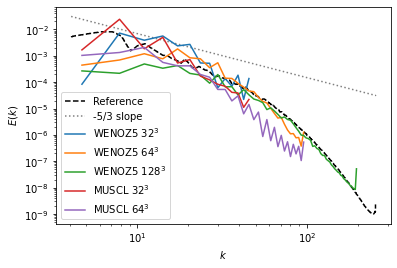

In [15]:
import matplotlib.pyplot as plt
import numpy as np

import yt

"""
Make a turbulent KE power spectrum.  Since we are stratified, we use
a rho**(1/3) scaling to the velocity to get something that would
look Kolmogorov (if the turbulence were fully developed).

Ultimately, we aim to compute:

                      1  ^      ^*
     E(k) = integral  -  V(k) . V(k) dS
                      2

             n                                               ^
where V = rho  U is the density-weighted velocity field, and V is the
FFT of V.

(Note: sometimes we normalize by 1/volume to get a spectral
energy density spectrum).

"""


def doit(ds):

    # a FFT operates on uniformly gridded data.  We'll use the yt
    # covering grid for this.

    max_level = ds.index.max_level

    ref = int(np.product(ds.ref_factors[0:max_level]))

    low = ds.domain_left_edge
    dims = ds.domain_dimensions * ref

    nx, ny, nz = dims

    nindex_rho = 0.5

    Kk = np.zeros((nx // 2 + 1, ny // 2 + 1, nz // 2 + 1))

    for vel in [("gas", "velocity_x"), ("gas", "velocity_y"), ("gas", "velocity_z")]:

        Kk += 0.5 * fft_comp(
            ds, ("gas", "density"), vel, nindex_rho, max_level, low, dims
        )

    # wavenumbers
    L = (ds.domain_right_edge - ds.domain_left_edge).d

    kx = 2 * np.pi * np.fft.rfftfreq(nx) * nx / L[0]
    ky = 2 * np.pi * np.fft.rfftfreq(ny) * ny / L[1]
    kz = 2 * np.pi * np.fft.rfftfreq(nz) * nz / L[2]

    # physical limits to the wavenumbers
    kmin = np.min(2.0 * np.pi / L)
    kmax = np.min(np.pi * dims / L)

    kbins = np.arange(kmin, kmax, kmin)
    N = len(kbins)

    # bin the Fourier KE into radial kbins
    kx3d, ky3d, kz3d = np.meshgrid(kx, ky, kz, indexing="ij")
    k = np.sqrt(kx3d**2 + ky3d**2 + kz3d**2)

    whichbin = np.digitize(k.flat, kbins)
    ncount = np.bincount(whichbin)

    E_spectrum = np.zeros(len(ncount) - 1)

    for n in range(1, len(ncount)):
        E_spectrum[n - 1] = np.sum(Kk.flat[whichbin == n])

    k = 0.5 * (kbins[0 : N - 1] + kbins[1:N])
    v0 = 3471.902257 
    rho0 = 0.001176528632
    E_spectrum = E_spectrum[1:N] / (nx * ny * nz) * v0 * rho0 #why???    

    plt.loglog(k, E_spectrum)
    plt.xlabel(r"$k$")
    plt.ylabel(r"$E(k)$")

def fft_comp(ds, irho, iu, nindex_rho, level, low, delta):

    cube = ds.covering_grid(level, left_edge=low, dims=delta, fields=[irho, iu])

    rho = cube[irho].d
    u = cube[iu].d

    nx, ny, nz = rho.shape

    # do the FFTs -- note that since our data is real, there will be
    # too much information here.  fftn puts the positive freq terms in
    # the first half of the axes -- that's what we keep.  Our
    # normalization has an '8' to account for this clipping to one
    # octant.
    ru = np.fft.fftn(rho**nindex_rho * u)[
        0 : nx // 2 + 1, 0 : ny // 2 + 1, 0 : nz // 2 + 1
    ]
    ru = 8.0 * ru / (nx * ny * nz)

    return np.abs(ru) ** 2

ref_sp = np.loadtxt("../../Exec/TGV/refdata/spectrum.txt", comments="#", delimiter=",")
plt.loglog(ref_sp[:,0], ref_sp[:,1], 'k--', label="Reference")

index = np.argmax(ref_sp[:,1])
kmax = ref_sp[index, 0]
Emax = ref_sp[index, 1]
plt.loglog(ref_sp[:,0], 2*Emax*(ref_sp[:,0]/kmax)**(-5./3.), ls=":", color="0.5")

ds = yt.load("../../Exec/TGV/wenoz5/32^3/plt03579")
doit(ds)

ds = yt.load("../../Exec/TGV/wenoz5/64^3/plt07261")
doit(ds)

ds = yt.load("../../Exec/TGV/wenoz5/128^3/plt14624")
doit(ds)

ds = yt.load("../../Exec/TGV/muscl/32^3/plt03581")
doit(ds)

ds = yt.load("../../Exec/TGV/muscl/64^3/plt07212")
doit(ds)

ds = yt.load("../../Exec/TGV/muscl/128^3/plt07212")
doit(ds)

# plt.loglog([32*np.pi/2, 32*np.pi/2], [1e-9, 1e-5], 'k--')
# plt.loglog([64*np.pi/2, 64*np.pi/2], [1e-9, 1e-7], 'k--')
# plt.loglog([128*np.pi/2, 128*np.pi/2], [1e-9, 1e-8], 'k--')

plt.legend(["Reference", "-5/3 slope", r"WENOZ5 $32^3$", r"WENOZ5 $64^3$", r"WENOZ5 $128^3$", r"MUSCL $32^3$", r"MUSCL $64^3$"])

plt.savefig("spectrum.png")